# Neural Network Model of Memory Retrieval

Replication of Recanatesi et al., 2015 https://www.frontiersin.org/articles/10.3389/fncom.2015.00149/full

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

from helpers import *

## 1. Initiation

1. Generate memories
2. Generate neuronal populations (dimensionality reduction)
3. Generate prototype connectivity matrix $J_{ij}$ without $\phi$
4. Build a hashmap of corresponding populations per memory

In [2]:
NUM_NEURONS = int(1e5)
NUM_MEMORIES = 16
SPARSITY = 0.01
EXCITATION_PARAM = 13000

In [3]:
# Generate memories and populations
memory_pattern = generate_memories(NUM_NEURONS, NUM_MEMORIES, SPARSITY)
pops, num_neurons_per_pop = generate_populations(memory_pattern)

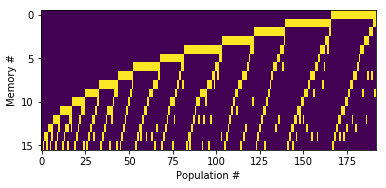

In [4]:
# Plot the populations
plt.figure()
plt.imshow(pops.T, aspect=5)
plt.xlabel('Population #')
plt.ylabel('Memory #')
plt.show()

In [5]:
# Generate protype connectivity matrix
proto_conn_mat = generate_proto_conn_matrix(pops, EXCITATION_PARAM, NUM_NEURONS, SPARSITY)

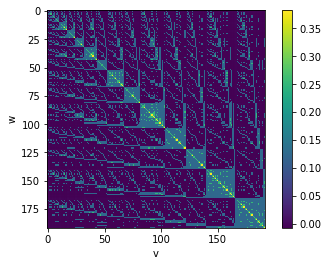

In [6]:
# Plot the prototype connectivity matrix
plt.figure()
plt.imshow(proto_conn_mat, aspect=1)
plt.xlabel('v')
plt.ylabel('w')
plt.colorbar()
plt.show()

In [7]:
# Build a hashmap of corresponding populations for each memory
pops_of_memory = defaultdict(list)
for j in range(NUM_MEMORIES):
    pops_of_memory[j] = list(np.where(pops[:,j]==1)[0])

## 2. Simulation of One Epoch

1. Generate a sequence of inhibition $\phi$
2. Start Simulation

In [54]:
PHI_MIN = 0.7
PHI_MAX = 1.06
TIME_STEP = 0.001
DECAY_TIME = 0.01
OSCILLATION_TIME = 1
TOTAL_TIME = 16
NOISE_VARIANCE = 65
INIT_RATE = 1
INIT_MEM = 7
GAIN_FUNC_THRES = 0
GAIN_FUNC_EXP = 0.4

In [9]:
# Generate phi
time_seq = np.arange(0, TOTAL_TIME, TIME_STEP)
phi_seq = generate_inhibition_seq(PHI_MIN, PHI_MAX, OSCILLATION_TIME, time_seq)

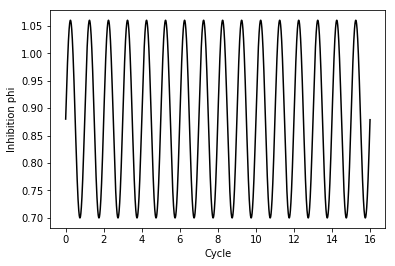

In [10]:
# Plot inhibition
plt.figure()
plt.plot(time_seq, phi_seq, 'k')
plt.xlabel('Cycle')
plt.ylabel('Inhibition phi')
plt.show()

In [84]:
# Initiate synaptic currents, averaging firing rates for each memory and noises
currs = np.zeros(len(pops))
avg_firing_rates = np.zeros((NUM_MEMORIES, len(time_seq)))
firing_rates = np.zeros(len(pops))
firing_rates[pops_of_memory[INIT_MEM]] += INIT_RATE

In [85]:
# Start Simulation
for j, t in tqdm(enumerate(time_seq)):
    # Update the connection matrix by including inhibition
#     conn_mat = proto_conn_mat - EXCITATION_PARAM / NUM_NEURONS * NUM_MEMORIES * phi_seq[j]
    conn_mat = proto_conn_mat - EXCITATION_PARAM / NUM_NEURONS * phi_seq[j]
    # Compute averaging firing rates for each memory
    for mu in range(NUM_MEMORIES):
        avg_firing_rates[mu, j] = np.average(firing_rates[pops_of_memory[mu]], 
                                             weights=num_neurons_per_pop[pops_of_memory[mu]])
    # Generate Noises
    noises = np.random.randn(len(firing_rates)) * np.sqrt(NOISE_VARIANCE) * 10
    noises /= np.sqrt(num_neurons_per_pop)
    # Update the averaging synaptic currents
    currs += TIME_STEP / DECAY_TIME * (-currs + conn_mat @ (firing_rates * num_neurons_per_pop) + \
                noises)
    # Update populational firing rates
    for k, curr in enumerate(currs):
        firing_rates[k] = gain_function(curr, GAIN_FUNC_THRES, GAIN_FUNC_EXP)

16000it [00:21, 743.12it/s]


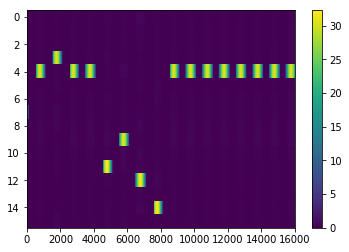

In [86]:
plt.imshow(avg_firing_rates, aspect='auto')
plt.colorbar()